In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import os
import cv2
import random
import ntpath

%matplotlib inline

In [2]:
np.random.seed(42)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## LOAD DATA

In [3]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv('driving_log.csv', index_col = None, names = columns)
data.head()

center  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   

                                                left  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   

                                               right  steering  throttle  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   

   reverse     speed  
0      0.0  0.000018  
1      0.0  0.000009  
2      0.0  0.000008  
3      0.0  0.000002  
4      0.0  0.000021

In [4]:
def img_name(path):
    head, tail = ntpath.split(path)
    return tail

In [5]:
data['center_img_nm'] = data['center'].apply(img_name)
data['right_img_nm'] = data['right'].apply(img_name)
data['left_img_nm'] = data['left'].apply(img_name)

In [6]:
data.head()

center  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   

                                                left  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...   

                                               right  steering  throttle  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...       0.0       0.0   

   reverse     speed                       center_img_nm  \
0      0.0  0.000018  center_2021_05_30_00_07_09_668.jpg   
1      0.0  0.000009  center_2021_05_30_00_07_09_737.jpg   
2      0.0  0.000008  center_2021_05_30_00_07_09_805.jpg   
3      0.0  0.000002  center_2021_05_30_00_07_09_876.jpg   
4      0.0  0.000021  center_2021_05_30_00_07_09_945.jpg   

                        right_img_nm                       left_img_nm  
0  right_2021_05_30_00_07_09_668.jpg  left_2021_05_30_00_07_09_668.jpg  
1  right_2021_05_30_00_07_09_737.jpg  left_2021_05_30_00_07_09_737.jpg  
2  right_2021_05_30_00_07_09_805.jpg  left_2021_05_30_00_07_09_805.jpg  
3  right_2021_05_30_00_07_09_876.jpg  left_2021_05_30_00_07_09_876.jpg  
4  right_2021_05_30_00_07_09_945.jpg  left_2021_05_30_00_07_09_945.jpg

In [7]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


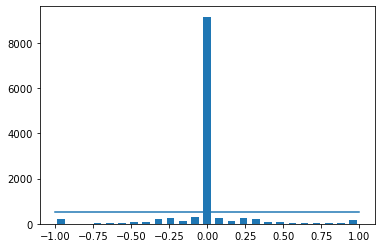

In [8]:
center = (bins[:-1] + bins[1:]) * 0.5 

threshold = 500  # To avoid steering bias

plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (threshold, threshold))

## PREPROCESSING DATA

### BALANCE STEERING DATA

In [9]:
print('TOTAL DATA', len(data))
biased_data = []

for j in range(num_bins):
    lst = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            lst.append(i)
    lst = shuffle(lst)
    lst = lst[threshold:]
    biased_data.extend(lst)
print('BIASED DATA', len(biased_data))

TOTAL DATA 11790
BIASED DATA 8660


In [10]:
data.drop(data.index[biased_data], inplace = True)
print('BALANCED DATA', len(data))

BALANCED DATA 3130


In [11]:
hist, _ = np.histogram(data['steering'], num_bins)

Text(0.5, 0, 'steering')

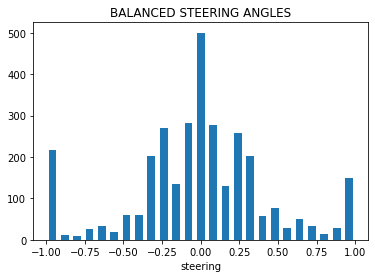

In [12]:
plt.bar(center, hist, width = 0.05)
plt.title('BALANCED STEERING ANGLES')
plt.xlabel('steering')

## TRAIN TEST SPLIT 
### IMAGE/STEERING DATA

In [13]:
df = data[data.columns[0:4]]
df = pd.melt(df,id_vars=['steering'])
df.drop('variable', axis = 1, inplace = True)
df.rename(columns = {'value': 'img_paths'}, inplace = True)
df.head()

steering                                          img_paths
0       0.0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...
1       0.0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...
2       0.0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...
3       0.0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...
4       0.0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde...

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df['img_paths'], df['steering'], test_size = 0.20, random_state = 42)

In [15]:
print('Training Samples', len(X_train))
print('Validation Samples', len(X_val))

Training Samples 7512
Validation Samples 1878


Text(0.5, 1.0, 'Validation Set')

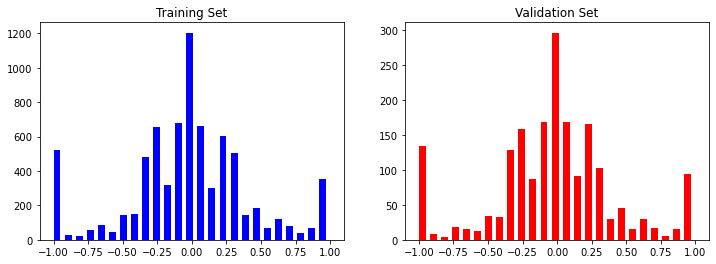

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(y_train, num_bins, width = 0.05, color = 'blue')
ax[0].set_title('Training Set')
ax[1].hist(y_val, num_bins, width = 0.05, color = 'red')
ax[1].set_title('Validation Set')

### IMAGE PREPROCESSING

### IMAGE DATA GENERATOR - DATA AUGMENTATION

#### ZOOM

In [53]:
def zoom(img):
    zoom = iaa.Affine(scale = (1, 1.3))
    img = zoom.augment_image(img)
    return img

Text(0.5, 1.0, 'Zoomed Image')

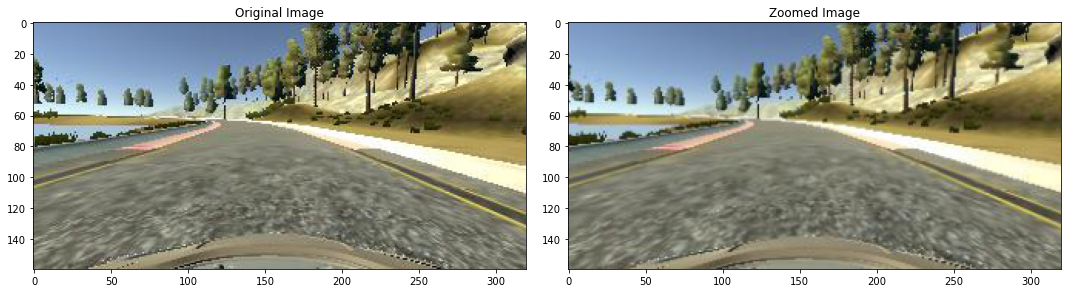

In [54]:
im_path = df['img_paths'][random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

zoomed_img = zoom(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(zoomed_img)
ax[1].set_title('Zoomed Image')

#### PAN

In [55]:
def pan(img):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    img = pan.augment_image(img)
    return img

Text(0.5, 1.0, 'Panned Image')

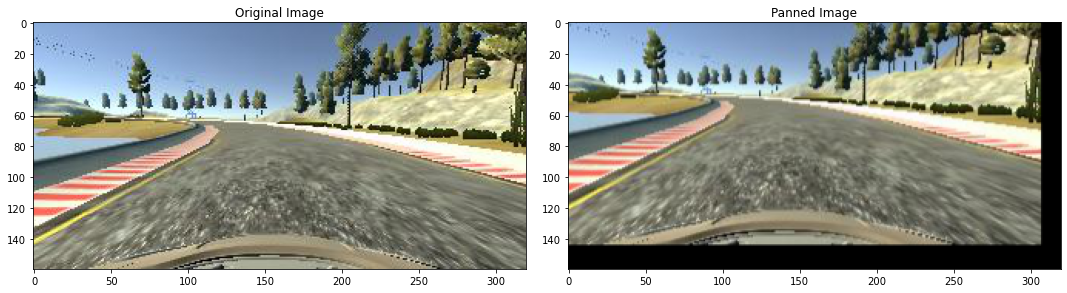

In [56]:
im_path = df['img_paths'][random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pan_img = pan(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(pan_img)
ax[1].set_title('Panned Image')

#### BRIGHTNESS

In [57]:
def img_random_brightness(img):
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)
    return img

Text(0.5, 1.0, 'Random Brightness Image')

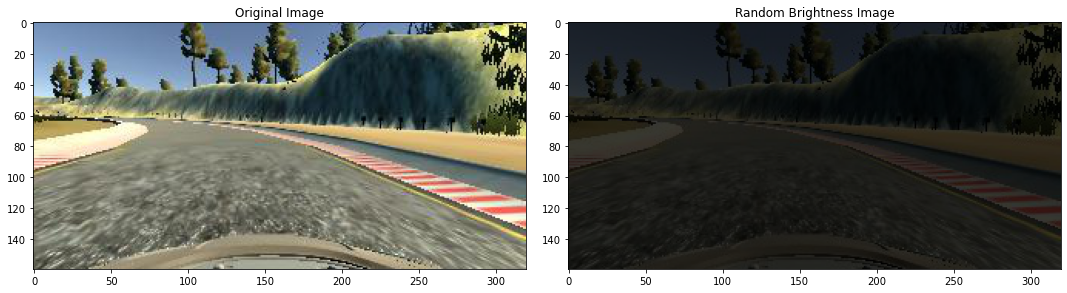

In [58]:
im_path = df['img_paths'][random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rb_img = img_random_brightness(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(rb_img)
ax[1].set_title('Random Brightness Image')

#### FLIP

In [64]:
def img_random_flip(img, steering_angle):
    img = cv2.flip(img,1)
    steering_angle = -steering_angle
    return img, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.15')

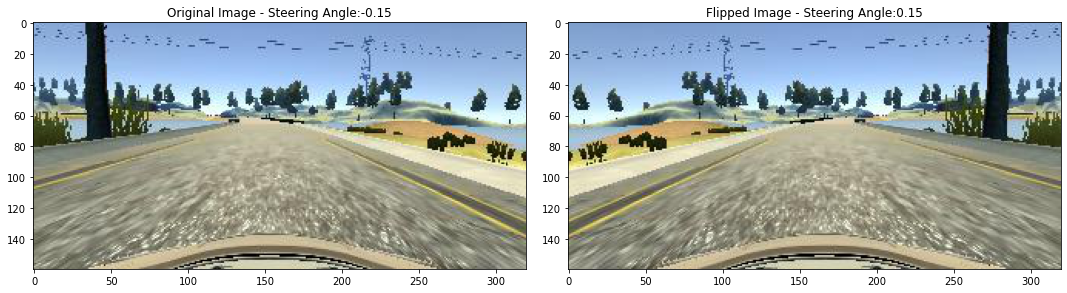

In [65]:
rand_index  = random.randint(0, 1000)
im_path = df['img_paths'][rand_index]
steering_angle = df['steering'][rand_index]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

flipped_img, flipped_steering_angle = img_random_flip(original_img, steering_angle)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
ax[1].imshow(flipped_img)
ax[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

#### RANDOM AUGMENTATION

In [61]:
def random_augment(img, steering_angle):
    img = mpimg.imread(img)
    
    if np.random.rand() < 0.5:
        img = pan(img)
    if np.random.rand() < 0.5:
        img = zoom(img)
    if np.random.rand() < 0.5:
        img = img_random_brightness(img)
    if np.random.rand() < 0.5:
        img, steering_angle = img_random_flip(img, steering_angle)
    
    return img, steering_angle

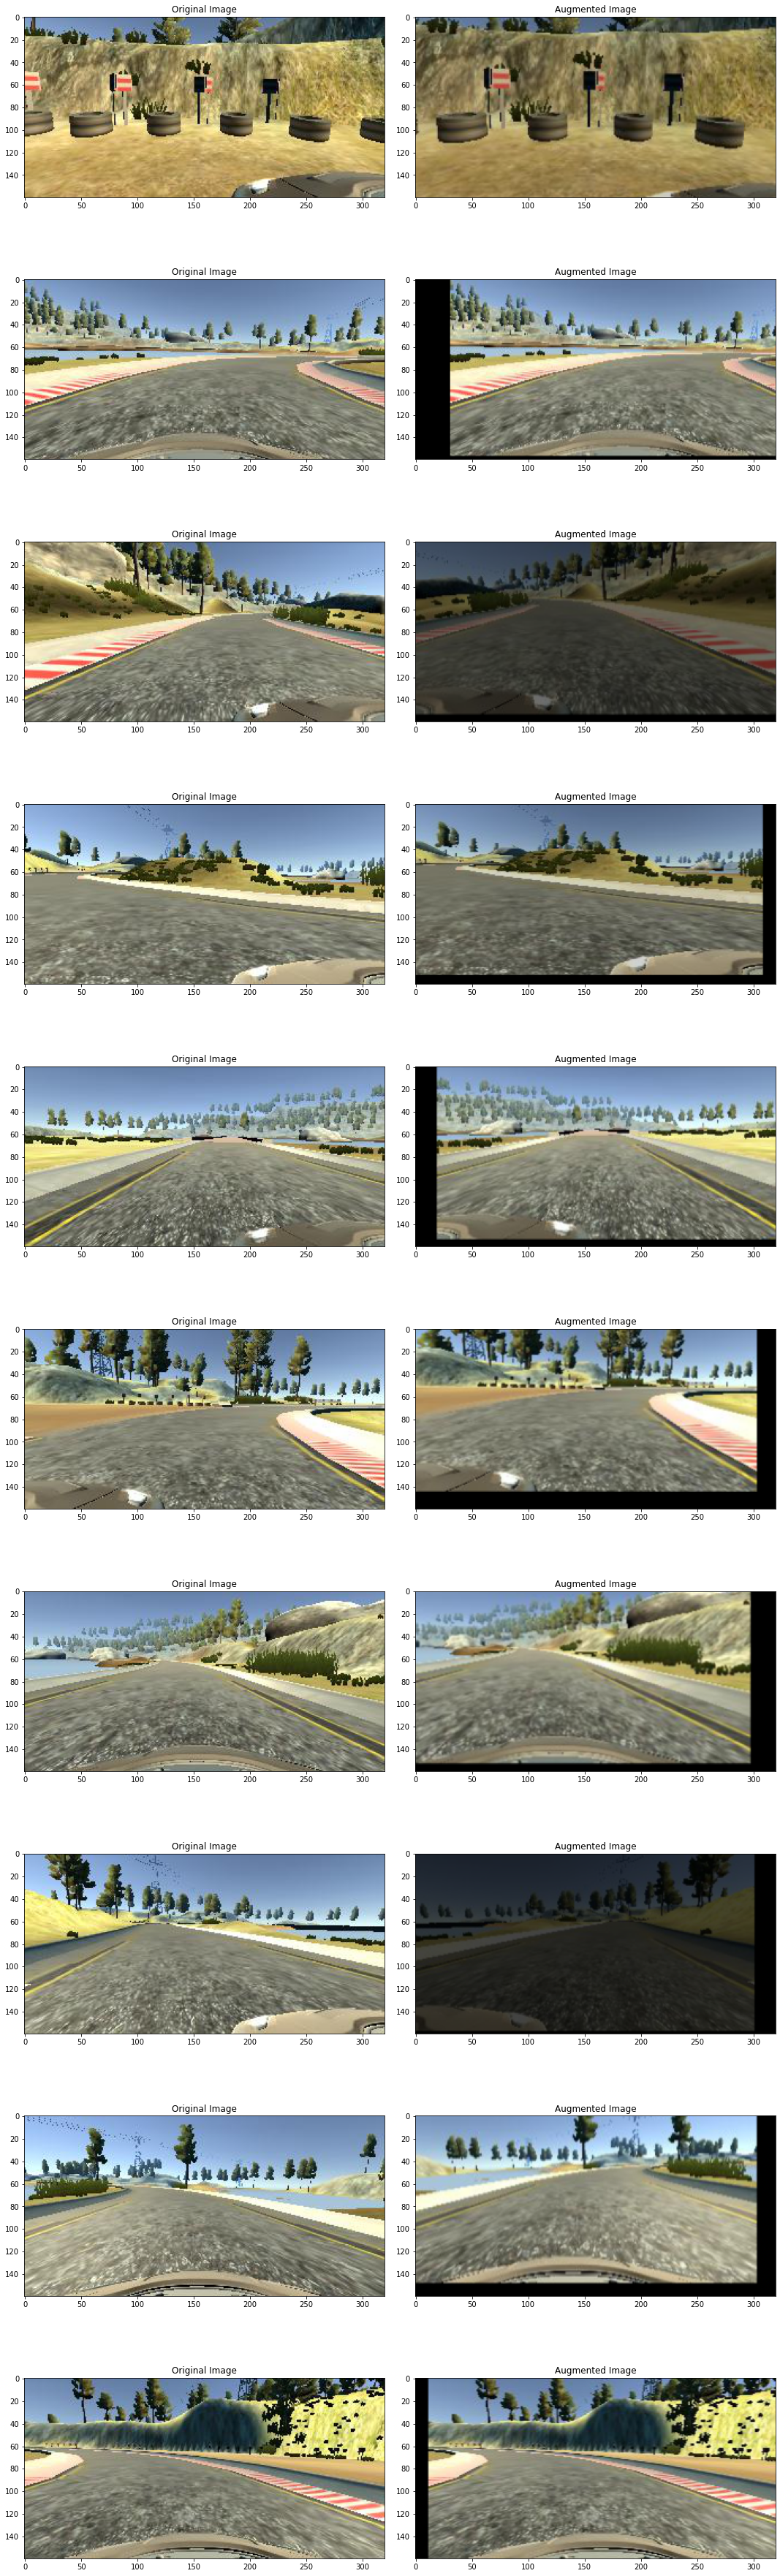

In [63]:
ncol = 2
nrow = 10
 
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    rand_num = random.randint(0, len(df) - 1)
    random_img = df['img_paths'][rand_num]
    random_steering = df['steering'][rand_num]
    
    original_img = cv2.imread(random_img)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    augmented_img, steering = random_augment(random_img, random_steering)
    
    ax[i][0].imshow(original_img)
    ax[i][0].set_title("Original Image")
  
    ax[i][1].imshow(augmented_img)
    ax[i][1].set_title("Augmented Image")

In [17]:
def img_preprocessing(img):
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # YUV CONVERSION
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    # CROP THE HOOD
    img = img[60:135, :, :]
    
    # NOISE REDUCTION - GAUSSIAN BLUR
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Resize Image
    img = cv2.resize(img, (200, 66))
    
    # Normalization
    img = img/255
    
    return img

Text(0.5, 1.0, 'Processed Image')

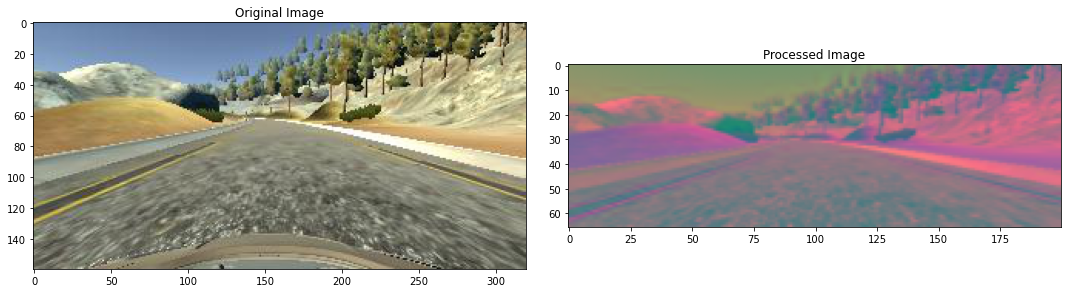

In [18]:
im_path = df['img_paths'][100]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processed_img = img_preprocessing(im_path)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(processed_img)
ax[1].set_title('Processed Image')

In [68]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    
    while True:
        batch_img = []
        batch_steering = []
        
    for i in range(batch_size):
        random_index = random.randint(0, len(image_paths) - 1)
        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
        else:
            im = mpimg.imread(image_paths[random_index])
            steering = steering_ang[random_index]
            
    im = img_preprocess(im)
    batch_img.append(im)
    batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [69]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_val_gen[0])
axs[1].set_title('Validation Image')

KeyboardInterrupt: 

In [19]:
X_train = np.array(list(map(img_preprocessing, X_train)))
X_val = np.array(list(map(img_preprocessing, X_val)))

(7512, 66, 200, 3)


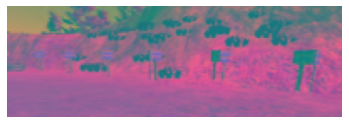

In [20]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

## MODELING

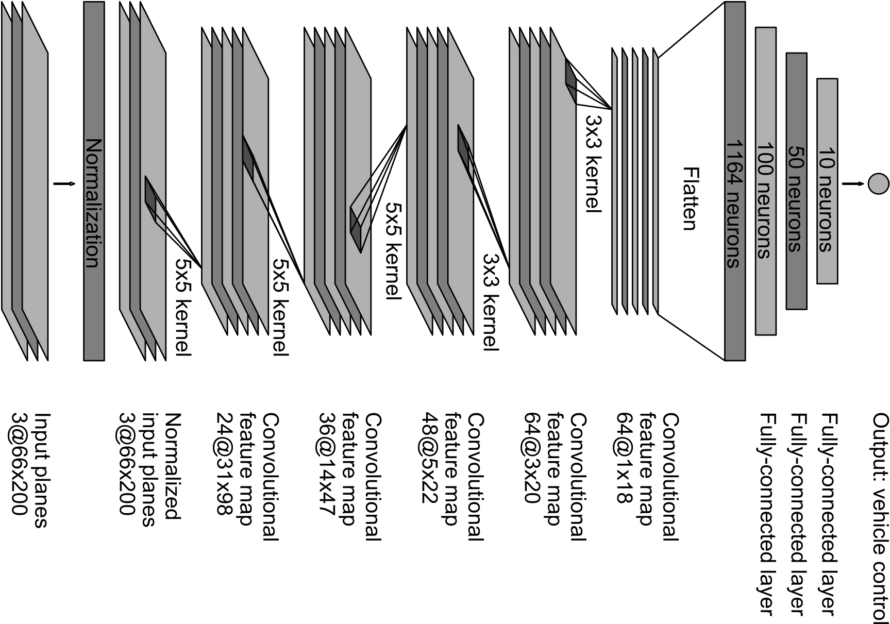

In [21]:
def nvidia_model():
 
    model = Sequential()

    model.add(Conv2D(24, kernel_size = (5,5), strides = (2,2), input_shape = (66,200,3), activation = 'elu'))
    model.add(Conv2D(36, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(48, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'elu'))
    model.add(Dropout(0.5))


    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation = 'elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))


    optimizer= Adam(learning_rate = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

In [22]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0